In [ ]:
import re
import pandas as pd
import nltk
import string
from plotly import graph_objects as go
# import plotly.express as px
import numpy as np

nltk.download("stopwords")
stopword_list = nltk.corpus.stopwords.words("english")


def read_file(filename):
    """
    Converts given text file into dataframe with cols of label and
    (positive, negative, neutral)
    """
    tweet_df = pd.read_csv(filename, sep="\t", lineterminator="\n")
    tweet_df.columns = ["label", "tweet"]
    return tweet_df


# TODO: replace contractions? emojis?
def clean_tweet(tweet):
    """
    tweet: string
    returns: cleaned tweet (string)
    """
    tweet = tweet.lower()
    # remove punctuation
    tweet = "".join([c for c in tweet if c not in string.punctuation])
    # remove stop words
    tweet = "".join([(c + " ") for c in tweet.split(" ") if c not in stopword_list])
    # remove all @mentions
    tweet = re.sub(r"(@.*?)[\s]", " ", tweet)
    # remove twitter URL at end of tweet (https://t.co/...)
    tweet = re.sub("http[s]?://\S+", "", tweet)
    return tweet


def visualize_tweets(tweet_df):
    """
    tweet_df: dataframe
    """
    index = ["negative", "neutral", "positive"]

    tweet_u, tweet_counts = np.unique(tweet_df["label"], return_counts=True)
    text = [round(x / len(tweet_df), 3) for x in tweet_counts]
    fig = go.Figure(
        data=[
            go.Bar(
                name="Tweets",
                x=index,
                y=tweet_counts / len(tweet_df),
                text=text,
            ),
        ],
        layout=go.Layout(
            title="Proportion of Tweets by Sentiment",
            yaxis_title="Proportion of Total Tweets",
        ),
    )
    fig.show()


def preprocess_tweets(filename):
    tweet_df = read_file(filename)
    tweet_df["tweet"] = tweet_df["tweet"].apply(clean_tweet)
    return tweet_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import nltk
from textblob import TextBlob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")

label_dict = {"negative": 0, "neutral": 1, "positive": 2}

def extract_features(filename):
    tweets_df = preprocess_tweets(filename)

    sid = SentimentIntensityAnalyzer()
    tweets_df["sentiment"] = tweets_df["tweet"].apply(
        lambda x: sid.polarity_scores(x).get("compound")
    )
    tweets_df["subjectivity"] = tweets_df["tweet"].apply(
        lambda x: TextBlob(x).sentiment.subjectivity
    )
    tweets_df["num_tokens"] = tweets_df["tweet"].apply(lambda x: len(x.split(" ")))
    tweets_df["label"] = tweets_df["label"].apply(lambda x : label_dict[x])

    return tweets_df

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


0.5631399317406144

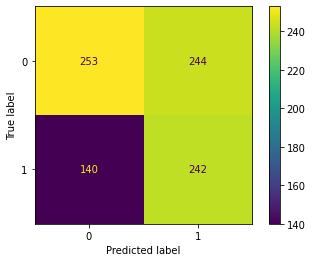

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# def get_sentiment_label(x):
#   if (x < -0.05):
#     return -1
#   if (x > 0.05):
#     return 1
#   else:
#     return 0

def get_sentiment_label(x):
  if (x < 0):
    return 0
  if (x >= 0):
    return 1

def baseline_predictor():
    tweets_df = extract_features("final_tweets_test.txt")
    tweets_df=tweets_df[tweets_df.label != 2]
    tweets_df["prediction"] = tweets_df["sentiment"].apply(get_sentiment_label)
    correct_prediction = tweets_df[tweets_df["prediction"] == tweets_df["label"]]
    accuracy = len(correct_prediction) / len(tweets_df)


    ConfusionMatrixDisplay.from_predictions(tweets_df["label"], tweets_df["prediction"])

    return accuracy

baseline_predictor()

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 4.0 MB 4.6 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 895 kB 55.8 MB/s 
     |████████████████████████████████| 596 kB 12.8 MB/s 
     |████████████████████████████████| 6.6 MB 53.8 MB/s 


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures


# model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
test_tweets_df = preprocess_tweets("final_tweets_test.txt")
train_tweets_df=preprocess_tweets("final_tweets_training.txt")
label_dict = {"negative": 0, "neutral": 2, "positive": 1}
test_tweets_df["label"] = test_tweets_df["label"].apply(lambda x : label_dict[x])
train_tweets_df["label"] = train_tweets_df["label"].apply(lambda x : label_dict[x])

#drop neutral
test_tweets_df=test_tweets_df[test_tweets_df.label != 2]
train_tweets_df=train_tweets_df[train_tweets_df.label != 2]

In [ ]:
test_tweets_df
# train_tweets_df

train,val = train_test_split(test_tweets_df, test_size=0.2)

In [ ]:
val

,label,tweet
350,0,told fake news guess fake senate httpstcouem9p...
1081,0,trump nj peddling lies we’ll continue working ...
681,1,thanks twatter reminding im old httpstcovqiktv...
1183,0,kudos saying gop senator admit realdonaldtrump...
440,0,hajdu said health canada maintains evidence vi...
...,...,...
150,0,larry kudlow coronavirus still argue contained
994,1,bagged first place nysc benue state awards ded...
1104,0,good morning president admitted north star cor...
1198,1,bigil complete 100 days box office week could ...


In [ ]:
from transformers import InputExample, InputFeatures
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=60):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'tweet'
LABEL_COLUMN = 'label'

In [ ]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, val, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [ ]:
model.fit(train_data, epochs=3, validation_data=validation_data)

Epoch 1/3
46/46 [==============================] - 45s 450ms/step - loss: 0.4237 - accuracy: 0.8087 - val_loss: 0.4488 - val_accuracy: 0.8453
Epoch 2/3
46/46 [==============================] - 18s 387ms/step - loss: 0.1599 - accuracy: 0.9510 - val_loss: 0.4982 - val_accuracy: 0.8453
Epoch 3/3
46/46 [==============================] - 18s 389ms/step - loss: 0.0603 - accuracy: 0.9855 - val_loss: 0.5628 - val_accuracy: 0.8619


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

0.861878453038674


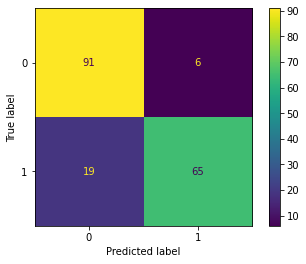

In [ ]:
pred_sentences=val['tweet'].values.tolist()

tf_batch = tokenizer(pred_sentences, max_length=60, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
ConfusionMatrixDisplay.from_predictions(val["label"], label)
print(accuracy_score(val['label'],label))


0.5685


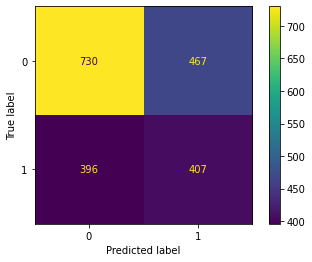

In [ ]:
low=1000
hi=3000
pred_sentences=train_tweets_df['tweet'].values.tolist()[low:hi]

tf_batch = tokenizer(pred_sentences, max_length=60, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1) 
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
ConfusionMatrixDisplay.from_predictions(train_tweets_df["label"][low:hi], label)
print(accuracy_score(train_tweets_df["label"][low:hi],label))

# ConfusionMatrixDisplay.from_predictions(test_tweets_df["label"], label)
# print(accuracy_score(test_tweets_df["label"],label))